In [1]:
#in house cnn
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from copy import deepcopy
from tqdm import tqdm

In [2]:
root = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
train  = pd.read_csv(root + 'train.csv')
label = pd.read_csv(root + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(root + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(root + 'test_series_descriptions.csv')
sub         = pd.read_csv(root + 'sample_submission.csv')
conditions = {}

In [3]:
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

In [4]:
# Function to generate image paths based on directory structure
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)



In [5]:
def reshape_row_2(row):
    # Create dictionary to store levels and severities
    conditions = {}

    # Add level-severity pair directly from the row's values
    level = row['level']
    severity = row['severity']
    
    # Populate the conditions dictionary with level and severity
    conditions[level] = severity
    
    # Return a dictionary with the original row values and new 'conditions' column
    return {
        'study_id': row['study_id'],
        'series_id': row['series_id'],
        'instance_number': row['instance_number'],
        'conditions': conditions
    }

In [6]:
train_image_paths = generate_image_paths(train_desc, f'{root}/train_images')
test_image_paths = generate_image_paths(test_desc, f'{root}/test_images')

In [7]:
train = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

In [8]:
#join the labels with the train dataset
train = pd.merge(train, label, on=['study_id', 'condition', 'level'], how='inner')
train = pd.merge(train, train_desc, on=['series_id','study_id'], how='inner')


In [9]:
train["severity"] = train["severity"].map({'Normal/Mild':0, 'Severe':2, 'Moderate':1})
train = train.dropna()
train.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,0.0,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,0.0,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,0.0,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,0.0,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,0.0,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [10]:
train['image_path'] = (
    f'{root}/train_images/' + 
    train['study_id'].astype(str) + '/' +
    train['series_id'].astype(str) + '/' +
    train['instance_number'].astype(str) + '.dcm'
)
train.head(2)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,0.0,702807833,8,322.831858,227.964602,Sagittal T2/STIR,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,0.0,702807833,8,320.571429,295.714286,Sagittal T2/STIR,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [11]:
import os

# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{root}/train_images/{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{root}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the functions to the train_data dataframe
train['study_id_exists'] = train.apply(check_study_id, axis=1)
train['series_id_exists'] = train.apply(check_series_id, axis=1)
train['image_exists'] = train.apply(check_image_exists, axis=1)

# Filter train_data
train = train[(train['study_id_exists']) & (train['series_id_exists']) & (train['image_exists'])]
train.head(4)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,0.0,702807833,8,322.831858,227.964602,Sagittal T2/STIR,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,0.0,702807833,8,320.571429,295.714286,Sagittal T2/STIR,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,0.0,702807833,8,323.030303,371.818182,Sagittal T2/STIR,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,0.0,702807833,8,335.292035,427.327434,Sagittal T2/STIR,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True


In [12]:
# Dictionary to store grouped data
grouped_data = {}

# Loop through each row and build the dictionary for each unique (study_id, series_id, instance_number) combination
for _, row in train.iterrows():
    key = (row['study_id'], row['series_id'], row['instance_number'])
    
    # Initialize a new entry in the grouped_data dictionary if this key is not yet present
    if key not in grouped_data:
        grouped_data[key] = {
            'study_id': row['study_id'],
            'series_id': row['series_id'],
            'instance_number': row['instance_number'],
            'condition':row['condition'],
            'conditions': {},
            'series_description':row['series_description'],
            'image_path':row['image_path']
        }
    
    # Add the level-severity pair to the conditions dictionary for this key
    grouped_data[key]['conditions'][row['level']] = row['severity']

# Convert the grouped data dictionary to a DataFrame
train_transformed = pd.DataFrame(grouped_data.values())

# Display the transformed DataFrame
train_transformed.head(2)
train = train_transformed

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
class MRIData(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  # Define this function to load your DICOM images
        
        # Convert the dictionary of conditions to a numpy vector
        conditions_dict = self.dataframe['conditions'][index]
        conditions_vector = self.conditions_to_vector(conditions_dict)
        
        # Optionally transform the image
        if self.transform:
            image = self.transform(image)

        return image, conditions_vector

    def conditions_to_vector(self, conditions_dict):
        # Example: Convert dictionary values to a numpy array (you may want to adjust ordering)
        levels = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']  # Adjust based on your data's levels
        vector = np.array([conditions_dict.get(level, 0) for level in levels])
        return vector

In [15]:
# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, transform, batch_size=8):
    filtered_df = df[df['series_description'] == series_description]
    
    train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = MRIData(train_df, transform)
    val_dataset = MRIData(val_df, transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, len(train_df), len(val_df)

In [16]:
def load_dicom(path):
    dc = pydicom.dcmread(path)
    data = dc.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [17]:
# Define the transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
class SpinalConditionCNN(nn.Module):
    def __init__(self, num_levels=5):  # Assuming 3 classes per level (e.g., normal, mild, severe)
        super(SpinalConditionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_levels)
        )
        
        self.num_levels = num_levels


    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = x.view(-1, self.num_levels)  # Shape (batch_size, num_levels)
        return x

In [20]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=100, device='cuda'):
    model = model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.view(-1, model.num_levels), labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted,_  = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate average loss for this epoch
        epoch_loss = running_loss / len(trainloader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.view(-1, model.num_levels), labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(valloader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
    # Plotting the loss and accuracy curves
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
        
        # Save best model
        

    print('Training complete')
    return model


Epoch [1/100], Train Loss: 1.0048, Train Acc: 0.0000, Val Loss: 0.7928, Val Acc: 0.0000
Epoch [2/100], Train Loss: 0.9469, Train Acc: 0.0000, Val Loss: 0.7921, Val Acc: 0.0000
Epoch [3/100], Train Loss: 0.9376, Train Acc: 0.0000, Val Loss: 0.8440, Val Acc: 0.0000
Epoch [4/100], Train Loss: 0.9197, Train Acc: 0.0000, Val Loss: 0.7922, Val Acc: 0.0040
Epoch [5/100], Train Loss: 0.9285, Train Acc: 0.0000, Val Loss: 0.7902, Val Acc: 0.0000
Epoch [6/100], Train Loss: 0.9244, Train Acc: 0.0000, Val Loss: 0.7932, Val Acc: 0.0000
Epoch [7/100], Train Loss: 0.9272, Train Acc: 0.0000, Val Loss: 0.7923, Val Acc: 0.0000
Epoch [8/100], Train Loss: 0.9236, Train Acc: 0.0000, Val Loss: 0.7930, Val Acc: 0.0000
Epoch [9/100], Train Loss: 0.9115, Train Acc: 0.0000, Val Loss: 0.8160, Val Acc: 0.0000
Epoch [10/100], Train Loss: 0.9231, Train Acc: 0.0000, Val Loss: 0.7876, Val Acc: 0.0000
Epoch [11/100], Train Loss: 0.9026, Train Acc: 0.0000, Val Loss: 0.7947, Val Acc: 0.0000
Epoch [12/100], Train Loss: 0.

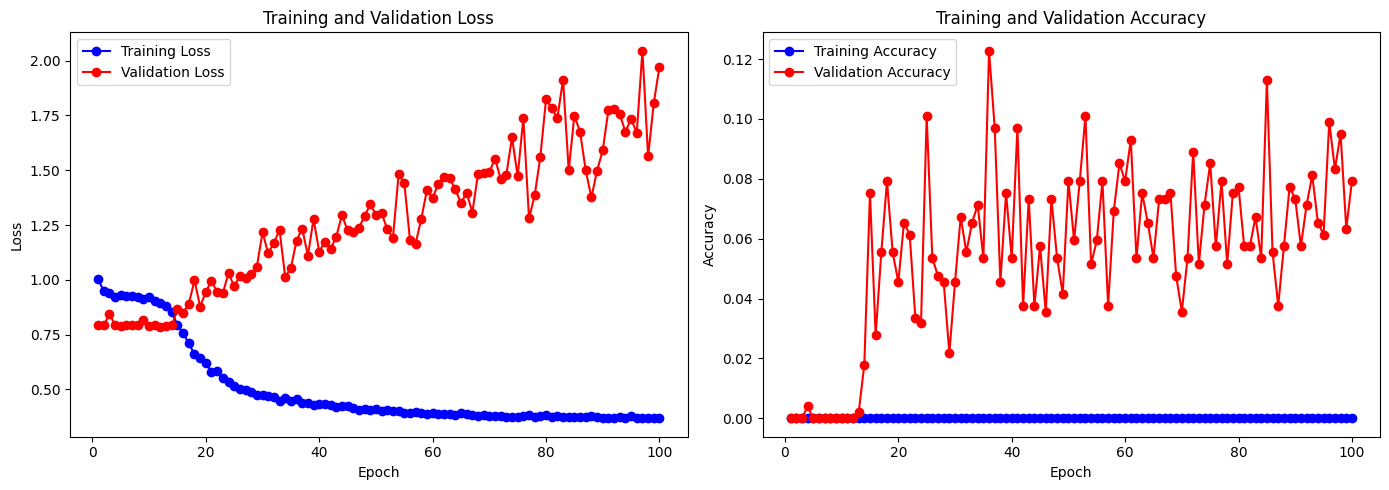

Training complete


In [21]:
# Assuming df is your dataframe with transformed conditions
trainloader, valloader, _, _ = create_datasets_and_loaders(train, series_description='Sagittal T2/STIR', transform=transform, batch_size=5)
# Initialize model, loss, and optimizer
model = SpinalConditionCNN(num_levels=5)  # Adjust num_classes based on the severity levels in your data
criterion = nn.CrossEntropyLoss()  # Assuming conditions are categorical with class labels for severity
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
trained_model = train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=100, device='cuda' if torch.cuda.is_available() else 'cpu')
torch.save(trained_model.state_dict(),'Sagittal_T2_STIR.pth')

In [22]:
# Assuming df is your dataframe with transformed conditions
trainloader_ax, valloader_ax, _, _ = create_datasets_and_loaders(train, series_description='Axial T2', transform=transform, batch_size=5)
# Initialize model, loss, and optimizer
model = SpinalConditionCNN(num_levels=5)  # Adjust num_classes based on the severity levels in your data
criterion = nn.CrossEntropyLoss()  # Assuming conditions are categorical with class labels for severity
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
trained_model = train_model(model, trainloader_ax, valloader_ax, criterion, optimizer, num_epochs=100, device='cuda' if torch.cuda.is_available() else 'cpu')
torch.save(trained_model.state_dict(),'Axial_T2.pth')

RuntimeError: The size of tensor a (3) must match the size of tensor b (5) at non-singleton dimension 1

In [ ]:
# Assuming df is your dataframe with transformed conditions
trainloader_t1, valloader_t1, _, _ = create_datasets_and_loaders(train, series_description='Sagittal T1', transform=transform, batch_size=5)
# Initialize model, loss, and optimizer
model = SpinalConditionCNN(num_levels=5)  # Adjust num_classes based on the severity levels in your data
criterion = nn.CrossEntropyLoss()  # Assuming conditions are categorical with class labels for severity
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
trained_model = train_model(model, trainloader_t1, valloader_t1, criterion, optimizer, num_epochs=100, device='cuda' if torch.cuda.is_available() else 'cpu')
torch.save(trained_model.state_dict(),'Sagittal_T1.pth')